# Normalizing Flux of Tau Ceti Using NEID Data


## This is what I'm supposed to do: 

In another notebook, we successfully normalzied Tau Ceti for a given order of the wavelength data. Now, the objective is to normalize the entire data set to achieve the average PSF value for the entire data set. Doing so will require there to be easy function calling to accomplish this instead of running this notebook multiple times. 


## Current Issues:

nothing to see here

## Importing Libraries:


In [1]:
#importing recommended libraries: 

from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

In [2]:
import seaborn as sns
sns.set_theme()

import pandas as pd

## Data set source:

use the following link: 

<https://neid.ipac.caltech.edu/search.php>

if it doesnt do it automatically, the object is HD 10700 and the data level is 1 

>The wavelength range Im looking for is pretty small, but somwhere with 5700 to 5900 angstroms is plenty to account for doppler shift

In [3]:
#reading in data and assigning it to arrays 
#for windows, the path needs double backslashes when copying as a location

star = 'HD 10700' 
data_path = "C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\neidL1_20220118T015112.fits"
# APF_flux_path = '/datag/blpd0/datax/apf/rarj.224.fits'

file = fits.open(data_path)
# fl_file = fits.open(APF_flux_path)
wl_raw_unfiltered = file['SCIWAVE'].data
flux_raw_unfiltered = file['SCIFLUX'].data

#so far I am only working with one file
type(wl_raw_unfiltered)

numpy.ndarray

In [4]:
file.info() #this just reads the table values in a simplifed format

Filename: C:\Users\alica\workspace\Intro-2-Spectra\analysis\NEID_analysis\neidL1_20220118T015112.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     745   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float64   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float64   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float64   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2451   (9216, 122)   float64   


_Now note here that the dimensions were obsviously 2d but I skimmed over that and didnt assign my values correctly, or maybe I did who knows that is yet to be determined (Alicia update this when you know whats going on thx)_

In [5]:
# #determing which row i want for the target wavelenght range 
c = 0
for i in wl_raw_unfiltered:
    print('row #',c,i)
    c+=1
    

row # 0 [nan nan nan ... nan nan nan]
row # 1 [nan nan nan ... nan nan nan]
row # 2 [0. 0. 0. ... 0. 0. 0.]
row # 3 [3570.94366863 3570.95346848 3570.96326784 ... 3640.05422442 3640.05950614
 3640.06478745]
row # 4 [3591.94333628 3591.95345481 3591.96357246 ... 3661.51064358 3661.51574867
 3661.52085301]
row # 5 [3613.47983488 3613.48968308 3613.49953093 ... 3683.3519227  3683.35720102
 3683.36247887]
row # 6 [3635.09951377 3635.10952498 3635.11953554 ... 3705.2899109  3705.29496654
 3705.3000213 ]
row # 7 [3656.83234385 3656.8427352  3656.85312549 ... 3727.53854074 3727.5434735
 3727.54840515]
row # 8 [3679.15733719 3679.16745836 3679.17757898 ... 3750.32452337 3750.3299075
 3750.33529112]
row # 9 [3701.75997064 3701.76988531 3701.77979978 ... 3773.43866104 3773.44447589
 3773.45029073]
row # 10 [3724.37146043 3724.38160951 3724.39175812 ... 3796.33909597 3796.34455912
 3796.35002178]
row # 11 [3747.35868185 3747.3689156  3747.37914884 ... 3819.76820514 3819.77368245
 3819.77915923]
r

In [6]:
# order = 10 #interger value

In [7]:
#this will be turned into a function later
# wl = wl_raw_unfiltered[order]
# flux = flux_raw_unfiltered[order]

## Removing Nan values in arrays

Sometimes the order of the array will have nan values in the array, for this we will first check if it does. if it doesnt, then the array can bypass this step and be pushed to the next section of normalization. 

Otherwise, we need to account for this issue and do some relative fitting/estimating

### removing and replacing nan value functions:

idea: do mean replacement for the time being (currently set eveything to 1 so delete when this is done)

In [9]:
def remove_nan(wl, flux): #this uses both of the below functions
    if check_nan(flux):
        wl , flux = find_and_replace_nan(wl, flux)
        # print('this array had nan values that have been replaced')
    # else:
        # print('this array didnt have nan values')
    return wl, flux

In [10]:
#checking for nan values, returns true if there are nan values in array
def check_nan(flux):
    has_nan = False
    for i in flux:
        if np.isnan(i):
            has_nan = True
    return has_nan

In [11]:
#finding values: -- there is a conversation to a np array, so if my code breaks it might be here --
def find_and_replace_nan(wl, flux):
    nan_wl = []
    for i in np.arange(len(flux)):
        if np.isnan(flux[i]):
            nan_wl.append(wl[i])
    nan_wl = np.array(nan_wl)
    #code above this point works
    new_wl = []
    new_flux = []
    for i in np.arange(len(wl)):
        new_wl.append(wl[i])
        if wl[i] in nan_wl: #for where there is a nan value:
            new_flux.append(1)
        else:
            new_flux.append(flux[i])
    return new_wl, new_flux
            
    
#this currently just sets it to 1 by default, but this could cause errors later 
            
        

## Removing Poor Fits
lets try just using the arrays that look like theyre accurate and see where that gets us!
> this will change the order as they correspond to the original data set. 

In [13]:
# making a dataframe of poor fit orders -- idk if this will come in handy but at least ill have it lol

poor_order_values = [0,1,2,3,4,5,6, 7, 8, 92, 93, 108, 115, 116, 117, 118, 119, 120, 121]
d = {'order': poor_order_values}

poor_orders = pd.DataFrame(data = d)
poor_orders

,order
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,92


In [14]:
wl_raw = []
flux_raw = []
for i in range(len(wl_raw_unfiltered)):
    if i not in poor_order_values:
        wl_raw.append(wl_raw_unfiltered[i])
        flux_raw.append(flux_raw_unfiltered[i])


## Plotting Order

In [15]:
import ipywidgets as widgets

#setting default repetition methods
slider = widgets.IntSlider(
    min=0,
    max=121,
    step=1,
    )


player = widgets.Play(interval = 1000, value = 0, min = 0,max =100)


In [16]:
def plot_orders(order = 0):
    plt.figure(figsize = (12,6))
    plt.title('Raw Data for Tau Ceti, Order: ' + str(order))
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Flux')
    wl = wl_raw[order]
    flux = flux_raw[order]
    
    plt.plot(wl, flux) 


In [18]:
widgets.interact(plot_orders, order = player)

interactive(children=(Play(value=0, description='order', interval=1000), Output()), _dom_classes=('widget-inte…

<function __main__.plot_orders(order=0)>

Awesome this totally works! At certain intervals it lags so only a few orders are shown, but at values above 500 it seems to show them all pretty okay.


Using plt.show() doesnt remove the text at the bottom of the plot

## Normalizing Flux as a Generic Function

This will find the echelle blaze values for each bin and then fit it to a curve, and then divide by that curve the raw data to normalize it to 1

In [19]:
def find_echelle_blaze_interact(order = 4):
    wl, flux = remove_nan(wl_raw[order],flux_raw[order])
    bin = 150 #modifying bins to even out the blaze function better 

    # this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
    indices = []

    for i in np.arange((len(wl) - (bin)), step = bin):
        flux_values = []
        for j in np.arange(i, i + bin, step = 1):
            value = flux[j]
            flux_values = np.append(flux_values, value)
        # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
        # but avoid issues with cosmic rays and other emission lines
        flux_in_bin = np.percentile(flux_values, 95)
        # find the closest value in the flux array to the 95th percentile value
        absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
        flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
        index_in_bin = flux_values.tolist().index(flux_in_bin)
        index = i + index_in_bin
        indices = np.append(indices, index)

    # these lists will contain the wavlength and flux values at each index in 'indices'
    wl_values = []
    fl_values = []

    for index in indices:
        ind = int(index)
        wl_values = np.append(wl_values, wl[ind])
        fl_values = np.append(fl_values, flux[ind])
        
    plt.figure(figsize = (12,6))
    plt.plot(wl, flux, label = 'Data')
    plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
    plt.title('Mapping out the Echelle Blaze Function Fit; order: ' + str(order))
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.legend()

In [21]:
widgets.interact(find_echelle_blaze_interact, order = widgets.Play(interval = 500, min = 0,max = len(wl_raw)))

interactive(children=(Play(value=0, description='order', interval=500, max=103), Output()), _dom_classes=('wid…

<function __main__.find_echelle_blaze_interact(order=4)>

now that we know it works we can just find it and not plot it, but in turn plot the echelle blaze function fit and then the next step and so forth and so forth. This technique will be used to make sure that each step of the way is working and can be plotted via wdget to look for errors. There will remain a widget version of each step but the final product will only plot the histogram of PSF values but be using the functions plotted along the way.


The data will be exported like the first notebook I used, but it will be full of all the normalized values and then do the same thing we did for one order but with all of them

In [54]:
def find_echelle_blaze(order = 4):
    wl, flux = remove_nan(wl_raw[order],flux_raw[order])
    bin = 150 #modifying bins to even out the blaze function better 

    # this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
    indices = []

    for i in np.arange((len(wl) - (bin)), step = bin):
        flux_values = []
        for j in np.arange(i, i + bin, step = 1):
            value = flux[j]
            flux_values = np.append(flux_values, value)
        # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
        # but avoid issues with cosmic rays and other emission lines
        flux_in_bin = np.percentile(flux_values, 95)
        # find the closest value in the flux array to the 95th percentile value
        absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
        flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
        index_in_bin = flux_values.tolist().index(flux_in_bin)
        index = i + index_in_bin
        indices = np.append(indices, index)

    # these lists will contain the wavlength and flux values at each index in 'indices'
    wl_values = []
    fl_values = []

    for index in indices:
        ind = int(index)
        wl_values = np.append(wl_values, wl[ind])
        fl_values = np.append(fl_values, flux[ind])

    return wl, flux, wl_values, fl_values

In [55]:
#Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. 
#Set s to 500000 to smooth the fit.
def echelle_blaze_fit_interact(order = 4):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    
    spl = splrep(wl_values, fl_values, s = 500000) #uses a B-Spline fitting method 
    flux_fit = splev(wl, spl)
    plt.figure(figsize = (12,6))
    plt.plot(wl, flux_fit)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Echelle Blaze Function Fit / Bin =' + str(bin) + ', Order:' + str(order), fontsize = 18)
    plt.show()

    #smooth this out 

In [56]:
widgets.interact(echelle_blaze_fit_interact, order = widgets.Play(interval = 500, min = 4,max = len(wl_raw)-2))

interactive(children=(Play(value=4, description='order', interval=500, max=120, min=4), Output()), _dom_classe…

<function __main__.echelle_blaze_fit_interact(order=4)>

In [57]:
#Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. 
#Set s to 500000 to smooth the fit.
def echelle_blaze_fit(order = 4):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    
    spl = splrep(wl_values, fl_values, s = 500000) #uses a B-Spline fitting method 
    flux_fit = splev(wl, spl)
    # plt.plot(wl, flux_fit)
    # plt.xlabel('Wavelength [A]')
    # plt.ylabel('Flux')
    # plt.title('Echelle Blaze Function Fit / Bin =' + str(bin) + ', Order:' + str(order), fontsize = 18)
    # plt.show()
    return flux_fit

    #smooth this out 

In [58]:
#this is supposed to divide the fit from the data and make it normalized
def normalized_flux_interact(order = 4, normalization = False):
    wl, flux, wl_values, fl_values = wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    
    first_normalized_flux = flux / flux_fit
    plt.figure(figsize = (12,6))
    plt.plot(wl, first_normalized_flux)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.ylim(-1,1.5)
    plt.title('Normalized Flux; Order: ' + str(order),fontsize = 18)
    if normalization:
        plt.axhline(1, c = 'red')
        
    plt.show()

In [59]:
widgets.interact(normalized_flux_interact, order = widgets.Play(interval = 400, min = 4,max = len(wl_raw)-2))  

#for slider: (4,100,1)
#for sim: widgets.Play(interval = 500, min = 4,max = len(wl_raw)-2)

interactive(children=(Play(value=4, description='order', interval=400, max=120, min=4), Checkbox(value=False, …

<function __main__.normalized_flux_interact(order=4, normalization=False)>

Some of these fits are absolutely terrible, considering whether its better to leave it or fix it. We'll see if we should just ignore the data sets on the edge of the spectrum, since in the middle the fits are pretty decent. 

In [60]:
#this is supposed to divide the fit from the data and make it normalized
def normalized_flux(order = 4, normalization = False):
    wl, flux, wl_values, fl_values = wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    
    first_normalized_flux = flux / flux_fit
#     plt.plot(wl, first_normalized_flux)
#     plt.xlabel('Wavelength [A]')
#     plt.ylabel('Flux')
#     plt.ylim(-1,1.5)
#     plt.title('Normalized Flux; Order: ' + str(order),fontsize = 18)
#     if normalization:
#         plt.axhline(1, c = 'red')
        
#     plt.show()
    return first_normalized_flux 

In [61]:
def second_normalized_flux_interact(order = 4):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    first_normalized_flux = normalized_flux(order)
    
    flux98 = np.percentile(first_normalized_flux, 98) #fixed the bug mentioned below 
    second_normalized_flux = first_normalized_flux / flux98
    plt.figure(figsize = (12,6))
    plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
    plt.plot(wl, second_normalized_flux, label = 'Normalized Twice')
    plt.legend()
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Double Normalized Data; Order: '+ str(order))
    plt.show()

In [62]:
widgets.interact(second_normalized_flux_interact, order = widgets.Play(interval = 400, min = 4,max = len(wl_raw)-2))  

interactive(children=(Play(value=4, description='order', interval=400, max=120, min=4), Output()), _dom_classe…

<function __main__.second_normalized_flux(order=4)>

In [68]:
def second_normalized_flux(order = 4):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    first_normalized_flux = normalized_flux(order)
    
    flux98 = np.percentile(first_normalized_flux, 98) #fixed the bug mentioned below 
    second_normalized_flux = first_normalized_flux / flux98
    
    return second_normalized_flux
    # plt.figure(figsize = (12,6))
    # plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
    # plt.plot(wl, second_normalized_flux, label = 'Normalized Twice')
    # plt.legend()
    # plt.xlabel('Wavelength [A]')
    # plt.ylabel('Flux')
    # plt.title('Double Normalized Data; Order: '+ str(order))
    # plt.show()

## Regriding the Wavelength Grid to be in Constant RV Space¶
Plot the normalized flux values onto the original wavelength grid, create a new wavelength grid that is log lambda spaced, and then interpolate onto the new wavelength grid. This will create a spectrum that is in constant RV space, which will allow for a straightforward calculation of the Doppler shift.

In [67]:
#this will be used to interpolate and hopefully it doesnt break lol
def interpolate(wl, normalized_flux):
    f = scipy.interpolate.interp1d(wl, normalized_flux, kind='cubic')
    return f

In [80]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
def wavelength_log_scale(order = 4):
    #stuff needed from other functions up to this point:
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    first_normalized_flux = normalized_flux(order)
    final_normalized_flux = second_normalized_flux(order)
    
    f = scipy.interpolate.interp1d(wl, final_normalized_flux, kind='cubic') #need to figure out how to modify this to work properly 
    
    dv = 1 # km/s  (?) why did she choose 1? 
    C = 299792.458 #km/s
    wl_start = min(wl) + 0.2
    wl_end = max(wl) - 0.2

    CDELT1 = np.log10(dv/C +1) # wavelength grid step size

    CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
    CRVALN = np.log10(wl_end)    # log of ending wavelength value 
    NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

    p = np.arange(NAXIS1) # array of total points
    wl2 = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

    # interpolate flux values onto log spaced wavelength grid
    flux2 = f(wl2)
    return wl2, flux2
    

In [102]:
def wavelength_log_scale_interact(order = 4):
    wl2, flux2 = wavelength_log_scale(order)
    plt.figure(figsize = (12,6))
    plt.plot(wl2, flux2)
    #plt.plot(wl,normalized_flux)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Data in Constant RV Space; Order:' + str(order))
    # plt.ylim(0.9,1)
    # plt.xlim(4800,4810)
    plt.show()

In [103]:
widgets.interact(wavelength_log_scale_interact, order = widgets.Play(interval = 1000, min = 4,max = len(wl_raw)-2)) #takes some time to run so account for that in the widget

interactive(children=(Play(value=4, description='order', interval=1000, max=120, min=4), Output()), _dom_class…

<function __main__.wavelength_log_scale_interact(order=4)>

## Solar Spectrum Stuff
Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to match the wavelength range of the APF data.

In [86]:
solar_spectrum_path = "C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\nso.fits"
solar_spectrum = fits.open(solar_spectrum_path)

In [87]:
solar_spectrum.info()

Filename: C:\Users\alica\workspace\Intro-2-Spectra\analysis\NEID_analysis\nso.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1097840,)   float64   
  1                1 ImageHDU         6   (1097840,)   float64   


In [98]:
#still need to go over:
def solar_spectrum_alterations(order = 4):
    wl2, flux2 = wavelength_log_scale(order)
    
    wl_temp = solar_spectrum[0].data
    fl_temp = solar_spectrum[1].data

    # wavelengths of APF data -- turning into my NEID data

    #this is giving the starting point of our data set:
    min_wl = min(wl2) - 8 #why 8 doe
    absolute_difference_function = lambda list_value: abs(list_value-min_wl)
    w = min(wl_temp.tolist(), key = absolute_difference_function)
    min_index = wl_temp.tolist().index(w)

    #this gives the end point:
    max_wl = max(wl2) + 8
    absolute_difference_function = lambda list_value : abs(list_value - max_wl)
    w = min(wl_temp.tolist(), key = absolute_difference_function)
    max_index = wl_temp.tolist().index(w)

    wl_syn_temp = wl_temp[min_index:max_index] #syn for synthetic?
    fl_syn_temp = fl_temp[min_index:max_index]
    
    #plotting
    plt.figure(figsize = (12,6))
    plt.plot(wl_syn_temp, fl_syn_temp)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Solar Spectrum')
    plt.show()

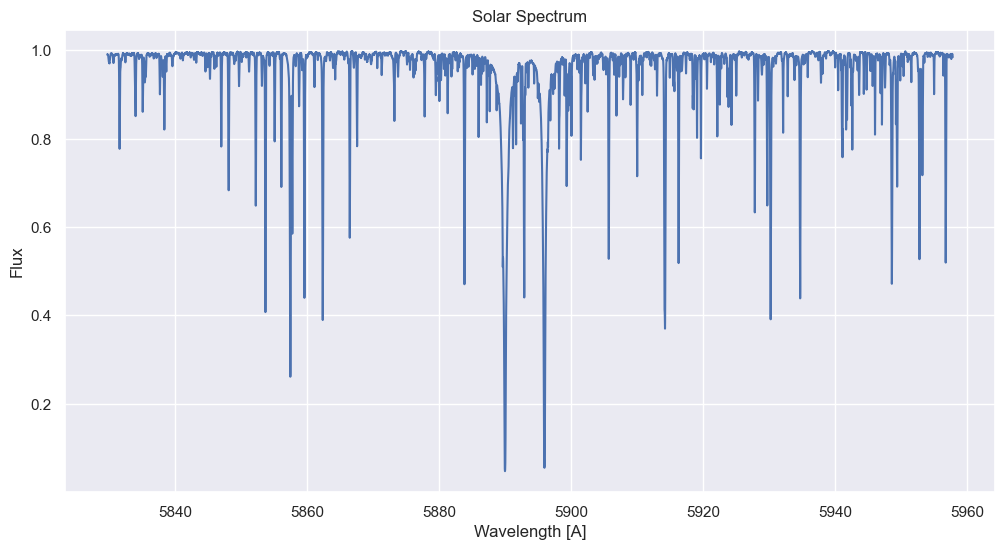

In [99]:
solar_spectrum_alterations(69)